In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from IPython.display import clear_output
import tensorflow as tf

!pip install nltk
import nltk
nltk.download('punkt')
clear_output()

if not os.path.exists("articles/"):
  !wget https://zenodo.org/record/1239675/files/articles.zip?download=1 -O articles.zip
  !unzip articles.zip
  !rm articles.zip
  clear_output()
  print("Data successfully downloaded")
else:
  print("Data already downloaded")


random_seed = 176249

Data already downloaded


# Clasificación de Orientaciones políticas

En este notebook vamos a tratar de predecir la orientación política del autor de una nota periodística a partir del texto de dicha nota.


El primer paso para ello es leer los datos. En este caso, se tiene un *data frame* con artículos de diarios y la anotación de la orientación política (*left*, *right* o *mainstream*).

In [3]:
def read_data(test_size=0.2,random_state=0):
  data = {
      # "author": [],
      # "title": [],
      "mainText": [],
      "orientation": [],
      # "veracity": []
  }
  index = []
  for filename in os.listdir("articles/"):
    root = ET.parse(f"articles/{filename}").getroot()
    index.append(int(filename.split(".")[0]))
    for elem in root:
      if elem.tag in data.keys():
        data[elem.tag].append(elem.text)
  data = pd.DataFrame(data,index=index)
  data = data[data.notna().all(axis="columns")]
  data = data.sample(frac=1,random_state=random_state)
  N = len(data)
  train_split, test_split = data.iloc[int(N*test_size):,:], data.iloc[:int(N*test_size),:]
  train_split = train_split.reset_index(drop=True)
  test_split = test_split.reset_index(drop=True)
  return train_split, test_split
  
train_split, test_split = read_data(test_size=0.2,random_state=random_seed)
train_split

,mainText,orientation
0,#5. Denmark pays students $900 a month to atte...,left
1,Politico POLITICO's must-read briefing on what...,mainstream
2,Dear President Bush. I am interested in buying...,right
3,Just days after the University of North Dakota...,left
4,Washington (CNN)The Senate Wednesday rejected ...,mainstream
...,...,...
1279,The rioters in Charlotte may think they’re pro...,right
1280,"Last October, Hillary Clinton and her top aide...",mainstream
1281,Kansas is bleeding money and jobs and Governor...,left
1282,To cap off a week in which police officers sho...,left


Una práctica muy común para procesar texto es normalizarlo. Algunas técnicas comunes son:
* Eliminar caracteres raros e inusuales
* Convertir todo a minúsculas
* Eliminar palabras que no contienen información relevante (*stop words*)
* *Lemmatization*
* *Stemming*

In [4]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino los stopwords
  if stop_words is not None:
    stop_words = "|".join(stop_words)
    normalized_corpus = normalized_corpus.str.replace(stop_words,"",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

train_data, test_data = read_data(test_size=0.2,random_state=random_seed)
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=None)
train_data

,mainText,orientation
0,5 denmark pays students 900 a month to attend ...,left
1,politico politicos mustread briefing on whats ...,mainstream
2,dear president bush i am interested in buying ...,right
3,just days after the university of north dakota...,left
4,washington cnnthe senate wednesday rejected a ...,mainstream
...,...,...
1279,the rioters in charlotte may think theyre prot...,right
1280,last october hillary clinton and her top aides...,mainstream
1281,kansas is bleeding money and jobs and governor...,left
1282,to cap off a week in which police officers sho...,left


Una vez preprocesado, es necesario definir el vocabulario. Es decir, el conjunto de palabras que van a ser consideradas en la extracción de *features*.

100%|██████████| 1284/1284 [00:05<00:00, 251.75it/s]


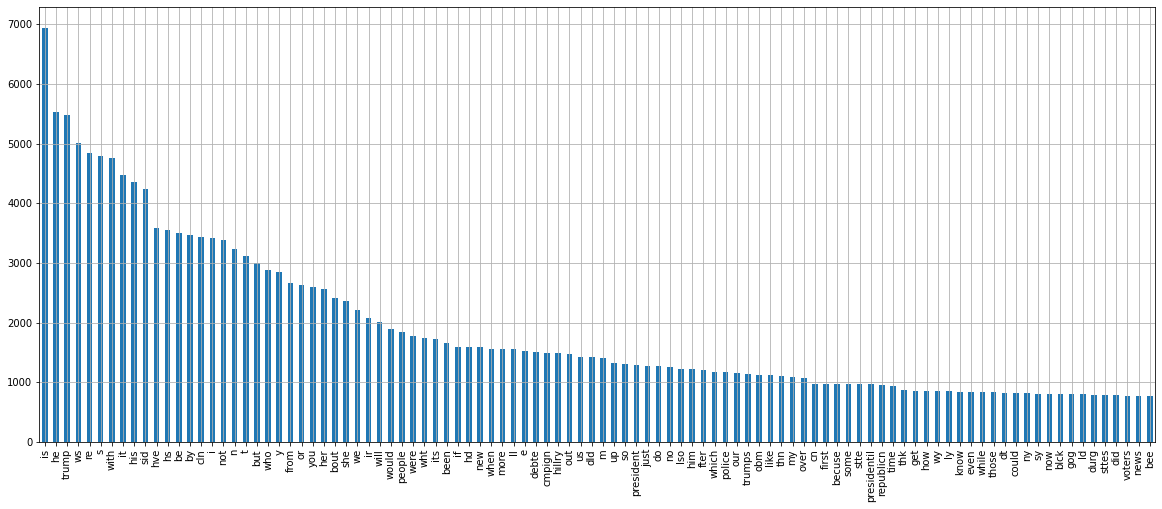

In [5]:
from nltk import word_tokenize
from collections import defaultdict

def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

Una vez hecho esto, es posible vectorizar cada noticia haciendo lo que se conoce como una "bolsa de palabras" (*bag of words*). Es decir, cada documento (noticia) de la base de datos va a consistir en un vecor que contenga en sus componentes la cantidad de veces que aparecieron las palabras del vocabulario en él. 

In [6]:
def vectorize(corpus,tokenizer,vocab):
  N = len(vocab)
  corpus_size = len(corpus)
  X = np.zeros((len(corpus),N))

  token2idx = {tk: i for i, tk in enumerate(vocab.index)}
  for i, article in enumerate(tqdm(corpus)):
    for w in tokenizer(article):
      if w in vocab.index:
        idx = token2idx[w]
        X[i,idx] += 1
  
  return X
        

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])

vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)
X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

100%|██████████| 320/320 [00:00<00:00, 429.32it/s]


## Baseline

*Show time!* Ahora sí vamos a clasificar noticias. Cuando tenemos una base de datos nueva, una buena práctica es utilizar un modelo ingénuo (*dummy* o *naive*) para evaluarlo. En clasificación es muy común utilizar un modelo que aprende cuál fue la clase más frecuente durante el entrenamiento y elige siempre ésta cuando tiene que realizar una predicción. Esto puede implementarse fácilmente utilizando el objeto `DummyClassifier` de [scikit-learn](https://scikit-learn.org/stable/index.html).

Para evaluar nuestro clasificación vamos a utilizar algunas funciones de la librería `metrics` del mismo paquete. En particular, `plot_confusion_matrix` nos muestra la matriz de confusión del problema de clasificación.

Baseline model:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       166
           1       0.00      0.00      0.00       109
           2       0.00      0.00      0.00        45

    accuracy                           0.52       320
   macro avg       0.17      0.33      0.23       320
weighted avg       0.27      0.52      0.35       320



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


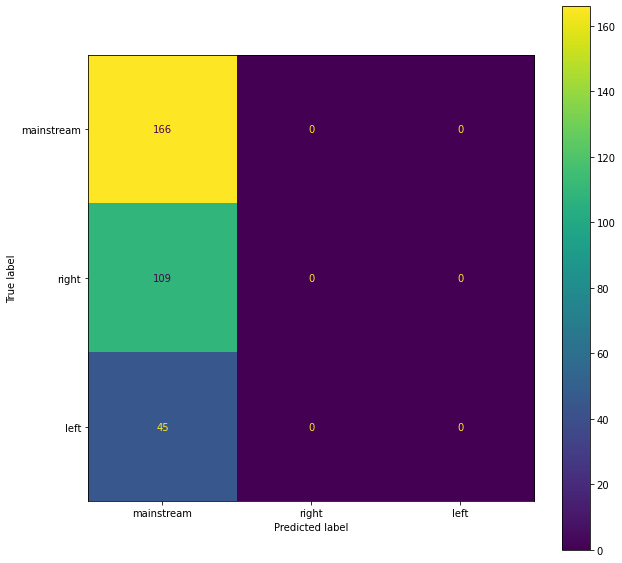

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

def show_results(y_true,y_pred):

  # Plot confusion matrix
  fig, ax = plt.subplots(1,1,figsize=(10,10))
  dsp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred,display_labels=["mainstream", "right", "left"],ax=ax)

  # Show Classification report
  print(classification_report(y_true,y_pred))


clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train,y_train)
y_test_pred = clf.predict(X_test)
print("Baseline model:")
show_results(y_test,y_test_pred)

## BOW + Clasificador Softmax

**Tarea 1: Implementar una vectorización por bolsa de palabras y entrenar un clasificador Softmax para clasificar orientaciones políticas. Utilizar exactitud como métrica de evaluación.**

Analizar:
* ¿Funciona mejor el clasificador entrenado que el modelo baseline?
* ¿Cómo influye la cantidad de palabras elegidas? ¿Y la frecuencia mínima de aparición? 
* ¿Qué importancia tienen las stop words en este caso?
* ¿Hay overfitting? ¿Cómo podría reducirlo?

In [10]:
def get_and_bow_vectorize_data(
    stop_words=None,
    max_tokens=10000,
    min_freq=1
):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=max_tokens,min_freq=min_freq)
  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_and_bow_vectorize_data()

# TODO: Implementar Softmax Classifier
def softmax(x):
    
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x



# END TODO

100%|██████████| 320/320 [00:00<00:00, 332.91it/s]


In [83]:
vocab

is          6941
he          5527
trump       5485
ws          5003
re          4840
            ... 
roseivey       5
chlked         5
mckenn         5
koltsov        5
nlytic         5
Length: 8953, dtype: int64

In [54]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim=10000))
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0022),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
hist = model.fit(x=X_train, y=y_train, batch_size = 1284, epochs=3000,callbacks=[es])

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 72ms/step - loss: 0.3936 - accuracy: 0.8886
Epoch 502/3000
1/1 [==============================] - 0s 70ms/step - loss: 0.3933 - accuracy: 0.8886
Epoch 503/3000
1/1 [==============================] - 0s 77ms/step - loss: 0.3930 - accuracy: 0.8886
Epoch 504/3000
1/1 [==============================] - 0s 79ms/step - loss: 0.3927 - accuracy: 0.8894
Epoch 505/3000
1/1 [==============================] - 0s 75ms/step - loss: 0.3924 - accuracy: 0.8894
Epoch 506/3000
1/1 [==============================] - 0s 78ms/step - loss: 0.3921 - accuracy: 0.8894
Epoch 507/3000
1/1 [==============================] - 0s 80ms/step - loss: 0.3918 - accuracy: 0.8894
Epoch 508/3000
1/1 [==============================] - 0s 80ms/step - loss: 0.3915 - accuracy: 0.8902
Epoch 509/3000
1/1 [==============================] - 0s 75ms/step - loss: 0.3912 - accuracy: 0.8902
Epoch 510/3000
1/1 [=========================

In [69]:
def predecir_orientacion_politica(x):
  return np.argmax(model.predict(x=x), axis = 1)

precision = (np.array(y_test) == predecir_orientacion_politica(X_test)).mean()
precision

0.8875

## Features selection

**Tarea 2: Implementar una vectorización por palabras claves. Es decir, definir un vocabulario inspeccionando las noticias de la base de datos y tratar de hipotetizar qué palabras pueden servir para discriminar entre noticias de izquierda, derecha y *mainstream*. Una  vez hecho esto, implementar nuevamente el clasificador anterior y utilizarlo para predecir en este nuevo escenario.**

Hint: para este análisis puede que sea necesario hacer una inspección de los datos y ver qué palabras aparecieron en cada categoría. En este punto, cualquier idea *out-of-the-box* también puede ser útil :)

In [78]:
train_split.loc[3, 'mainText']

'Just days after the University of North Dakota (UND) was nationally embarrassed over a student’s racist snap, the college is in hot water once again. In another Snapchat post that could potentially damage the university’s reputation and recruitment efforts for African American students, a group of white female students are seen wearing blackface, with the caption “Black Lives Matter.”  The snap was discovered just over 24 hours after a previous snap that three white female students posted after stealing an African American roommate’s phone and locking her out of her dorm room. In that post, three white female students are all smiling, and the caption on the photo reads, “Locked the black bitch out!”  While the university has already opened an investigation into the first photo, University of North Dakota Mark Kennedy said the second racist social media post in two days shows that the school has a lot of work to do to educate students on diversity, inclusion, and respect for others. In

In [13]:
def get_data_and_select_keywords(
    stop_words=None,
):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  # TODO: implementar selección de palabras claves.
  vocab = {'socialist': 0, 'americans': 0, 'corruption': 0, 'republican': 0, 'market': 0, 'poverty': 0, 'healthcare': 0, 'job': 0, 'property': 0, 'rights': 0, 'black': 0, 'supporter': 0, 'opposition': 0, 'radical': 0, 'left': 0, 'right': 0, 'decline': 0, 'racist': 0, "inclusion": 0, 'capitalism': 0}
  vocab = pd.Series(vocab)
  
  # END TODO

  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_data_and_select_keywords()

# TODO: Implementar Softmax Classifier

# END TODO

100%|██████████| 320/320 [00:00<00:00, 404.16it/s]


Epoch 1/3000


ValueError: ignored

In [16]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(3, input_dim=20))
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0022),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
hist = model2.fit(x=X_train, y=y_train, batch_size = 1284, epochs=3000,callbacks=[es])

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 15ms/step - loss: 1.0708 - accuracy: 0.4735
Epoch 502/3000
1/1 [==============================] - 0s 9ms/step - loss: 1.0704 - accuracy: 0.4751
Epoch 503/3000
1/1 [==============================] - 0s 13ms/step - loss: 1.0700 - accuracy: 0.4751
Epoch 504/3000
1/1 [==============================] - 0s 10ms/step - loss: 1.0696 - accuracy: 0.4751
Epoch 505/3000
1/1 [==============================] - 0s 14ms/step - loss: 1.0693 - accuracy: 0.4751
Epoch 506/3000
1/1 [==============================] - 0s 11ms/step - loss: 1.0689 - accuracy: 0.4743
Epoch 507/3000
1/1 [==============================] - 0s 177ms/step - loss: 1.0685 - accuracy: 0.4743
Epoch 508/3000
1/1 [==============================] - 0s 10ms/step - loss: 1.0681 - accuracy: 0.4743
Epoch 509/3000
1/1 [==============================] - 0s 13ms/step - loss: 1.0678 - accuracy: 0.4743
Epoch 510/3000
1/1 [=========================